In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
path_results = Path('/media/discoD/models/elmo/ner/results/')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/results/harem
/media/discoD/models/elmo/ner/results/harem-ft


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    results_model_folder = folder.iterdir()
    for training_folder in results_model_folder:
        #print('Reading files from %s' % training_folder.name)
        has_metrics = False
        for results_file in training_folder.iterdir():
            if results_file.name.endswith('.json'):
                #print('Parsing data from %s' % results_file.name)
                if results_file.name.startswith('config'):
                    configs[training_folder.name] = json.loads(results_file.read_bytes())
                elif results_file.name.startswith('metrics.'):
                    metrics[training_folder.name] = json.loads(results_file.read_bytes())
                    has_metrics = True
        if not has_metrics:
            print('metrics.json not found for %s' % training_folder.name)
            metrics[training_folder.name] = None

metrics.json not found for selective_harem_fasttext_64_0_0_4
metrics.json not found for selective_harem_fasttext_64_0_1_4
metrics.json not found for selective_harem_none_64_0_2_1
metrics.json not found for selective_harem_none_64_0_7_1
metrics.json not found for selective_harem_none_64_0_7_2
metrics.json not found for selective_harem_none_64_0_8_0
metrics.json not found for selective_harem_none_64_0_8_1
metrics.json not found for selective_harem_none_64_0_8_2
metrics.json not found for selective_harem_none_64_0_9_0
metrics.json not found for selective_harem_none_64_0_9_1
metrics.json not found for selective_harem_none_64_0_9_2
metrics.json not found for selective_harem_wang2vec_64_0_0_3
metrics.json not found for selective_harem_none_64_0_2_2
metrics.json not found for selective_harem_none_64_0_3_0
metrics.json not found for selective_harem_none_64_0_3_1
metrics.json not found for selective_harem_none_64_0_3_2
metrics.json not found for selective_harem_none_64_0_4_0
metrics.json not fo

In [5]:
len(metrics)

600

In [6]:
len(configs)

600

In [7]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()

In [8]:
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [9]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
EMBEDDING = 'Embedding'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'

In [10]:
columns = [TRAINING_ID, SCENARIO, MODEL, EMBEDDING, BATCH_SIZE, ELMO_DROPOUT, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]

In [11]:
columns

['Training_ID',
 'Scenario',
 'Model',
 'Embedding',
 'Batch_Size',
 'ELMo_Dropout',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [12]:
def get_elmo_dropout(config):
    return config['model']['text_field_embedder']['token_embedders']['elmo']['dropout']

def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    if len(data) == 6:
        #No ELMo dropout
        return {SCENARIO: data[0], MODEL: data[1], EMBEDDING: data[2], BATCH_SIZE: data[3], ELMO_DROPOUT: get_elmo_dropout(config), TRAINING_NUMBER: data[4]}
    elif len(data) == 7:
        #With ELMo dropout
        return {SCENARIO: data[0], MODEL: data[1], EMBEDDING: data[2], BATCH_SIZE: data[3], ELMO_DROPOUT: data[4], TRAINING_NUMBER: data[5], EXECUTION_NUMBER: data[6]}
    else:
        print('Invalid id: %s' % training_id)

In [13]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

In [14]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df

,Training_ID,Scenario,Model,Embedding,Batch_Size,ELMo_Dropout,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,selective_harem_fasttext_64_0_0_0,selective,harem,fasttext,64,0,0,0,7.0,10.0,00:08:58,538.0,53.80,0.995567,0.995914,0.952031,0.942017,0.946997,20.453259,0.978691,0.980330,0.799007,0.821429,0.810063,99.600985,0.976705,0.978492,0.810922,0.793322,0.802025,126.820293
1,selective_harem_fasttext_64_0_0_1,selective,harem,fasttext,64,0,0,1,8.0,10.0,00:09:25,565.0,56.50,0.995511,0.995869,0.951939,0.940129,0.945997,20.406128,0.978254,0.980549,0.809045,0.821429,0.815190,99.116940,0.976555,0.978371,0.818306,0.800000,0.809049,133.111303
2,selective_harem_fasttext_64_0_0_2,selective,harem,fasttext,64,0,0,2,9.0,10.0,00:09:24,564.0,56.40,0.995432,0.995768,0.948487,0.938511,0.943473,20.031290,0.979565,0.981095,0.788462,0.836735,0.811881,107.700358,0.977726,0.979242,0.808595,0.816694,0.812625,130.530884
3,selective_harem_fasttext_64_0_0_3,selective,harem,fasttext,64,0,0,3,14.0,20.0,00:19:04,1144.0,57.20,0.998657,0.998757,0.983514,0.981392,0.982451,5.633581,0.979784,0.981969,0.824561,0.839286,0.831858,133.910015,0.978326,0.980248,0.839085,0.795659,0.816795,180.545786
4,selective_harem_fasttext_64_0_0_4,selective,harem,fasttext,64,0,0,4,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,selective_harem_fasttext_64_0_0_5,selective,harem,fasttext,64,0,0,5,17.0,20.0,00:20:11,1211.0,60.55,0.998813,0.998892,0.985687,0.984358,0.985022,5.170068,0.980002,0.982297,0.822660,0.852041,0.837093,135.592096,0.977081,0.979047,0.831141,0.780634,0.805096,194.177318
6,selective_harem_fasttext_64_0_1_0,selective,harem,fasttext,64,0,1,0,9.0,10.0,00:09:28,568.0,56.80,0.995646,0.996020,0.946612,0.939736,0.943162,18.849870,0.987154,0.988349,0.867374,0.853786,0.860526,68.197759,0.977726,0.979467,0.825182,0.794324,0.809459,143.104361
7,selective_harem_fasttext_64_0_1_1,selective,harem,fasttext,64,0,1,1,6.0,10.0,00:09:30,570.0,57.00,0.995273,0.995658,0.944339,0.935701,0.940000,19.824817,0.987851,0.988747,0.857506,0.879896,0.868557,62.058962,0.976600,0.978462,0.792663,0.808013,0.800265,118.989284
8,selective_harem_fasttext_64_0_1_2,selective,harem,fasttext,64,0,1,2,6.0,10.0,00:09:50,590.0,59.00,0.995330,0.995737,0.943105,0.936508,0.939795,20.139821,0.987453,0.988349,0.852417,0.874674,0.863402,63.031611,0.976300,0.978221,0.795133,0.807346,0.801193,119.204913
9,selective_harem_fasttext_64_0_1_3,selective,harem,fasttext,64,0,1,3,19.0,20.0,00:21:01,1261.0,63.05,0.998564,0.998688,0.982215,0.980630,0.981422,6.008182,0.988747,0.989942,0.878553,0.887728,0.883117,76.929569,0.978041,0.979842,0.821782,0.803673,0.812627,185.888883


In [15]:
training_data_df = training_data_df[training_data_df.Scenario == 'selective']
len(training_data_df)

600

In [16]:
training_data_df.to_csv('training_data_20_epochs.csv')

In [17]:
training_data_df.groupby([BATCH_SIZE]).describe()[TOTAL_DURATION]

,count,mean,std,min,25%,50%,75%,max
Batch_Size,,,,,,,,
64,521.0,900.059501,301.250481,538.0,576.0,1142.0,1176.0,1322.0


In [18]:
training_data_df.groupby([BATCH_SIZE]).describe()[TEST_F1_MEASURE]

,count,mean,std,min,25%,50%,75%,max
Batch_Size,,,,,,,,
64,521.0,0.811218,0.005823,0.782669,0.807499,0.811589,0.814815,0.829045


In [19]:
training_data_df.groupby([BATCH_SIZE, MODEL]).describe()[TEST_F1_MEASURE]

count      mean       std       min       25%       50%  \
Batch_Size Model                                                               
64         harem     260.0  0.810798  0.005862  0.795202  0.806989  0.811464   
           harem-ft  261.0  0.811637  0.005765  0.782669  0.807907  0.811901   

                          75%       max  
Batch_Size Model                         
64         harem     0.814448  0.824146  
           harem-ft  0.815311  0.829045

In [20]:
training_data_df.groupby([ELMO_DROPOUT]).describe()[TEST_F1_MEASURE]

,count,mean,std,min,25%,50%,75%,max
ELMo_Dropout,,,,,,,,
0,521.0,0.811218,0.005823,0.782669,0.807499,0.811589,0.814815,0.829045


In [21]:
training_data_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE]

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
fasttext,116.0,0.809858,0.005438,0.782669,0.806985,0.810690,0.813203,0.822424
glove,116.0,0.812160,0.006388,0.795282,0.808109,0.812596,0.815917,0.827282
none,56.0,0.812437,0.005182,0.799527,0.808822,0.812463,0.815830,0.822125
wang2vec,116.0,0.811950,0.005947,0.795095,0.808253,0.812489,0.814970,0.829045
word2vec,117.0,0.810324,0.005446,0.795202,0.806726,0.810757,0.814612,0.820852


In [22]:
training_data_df.groupby([EMBEDDING, MODEL]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean       std       min       25%       50%  \
Embedding Model                                                               
glove     harem-ft   57.0  0.813311  0.006447  0.798899  0.808403  0.814013   
none      harem-ft   29.0  0.812746  0.004094  0.805985  0.809443  0.811951   
wang2vec  harem-ft   58.0  0.812134  0.005679  0.795095  0.808311  0.812473   
none      harem      27.0  0.812105  0.006207  0.799527  0.807842  0.812779   
wang2vec  harem      58.0  0.811767  0.006247  0.797571  0.808276  0.812515   
glove     harem      59.0  0.811048  0.006182  0.795282  0.807817  0.812383   
word2vec  harem-ft   59.0  0.810397  0.005468  0.798219  0.806558  0.811177   
          harem      58.0  0.810250  0.005470  0.795202  0.806740  0.810295   
fasttext  harem-ft   58.0  0.810203  0.005700  0.782669  0.807503  0.811091   
          harem      58.0  0.809513  0.005190  0.796920  0.806375  0.810203   

                         75%       max  
Embedding Model                         
glove     harem-ft  0.818584  0.827282  
none      harem-ft  0.815658  0.820407  
wang2vec  harem-ft  0.814778  0.829045  
none      harem     0.816352  0.822125  
wang2vec  harem     0.816067  0.824146  
glove     harem     0.814257  0.821913  
word2vec  harem-ft  0.814765  0.819661  
          harem     0.814321  0.820852  
fasttext  harem-ft  0.813223  0.820697  
          harem     0.813052  0.822424

In [23]:
training_data_df.groupby([SCENARIO, BATCH_SIZE, EMBEDDING, MODEL]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean       std       min  \
Scenario  Batch_Size Embedding Model                                           
selective 64         glove     harem-ft   57.0  0.813311  0.006447  0.798899   
                     none      harem-ft   29.0  0.812746  0.004094  0.805985   
                     wang2vec  harem-ft   58.0  0.812134  0.005679  0.795095   
                     none      harem      27.0  0.812105  0.006207  0.799527   
                     wang2vec  harem      58.0  0.811767  0.006247  0.797571   
                     glove     harem      59.0  0.811048  0.006182  0.795282   
                     word2vec  harem-ft   59.0  0.810397  0.005468  0.798219   
                               harem      58.0  0.810250  0.005470  0.795202   
                     fasttext  harem-ft   58.0  0.810203  0.005700  0.782669   
                               harem      58.0  0.809513  0.005190  0.796920   

                                              25%       50%       75%  \
Scenario  Batch_Size Embedding Model                                    
selective 64         glove     harem-ft  0.808403  0.814013  0.818584   
                     none      harem-ft  0.809443  0.811951  0.815658   
                     wang2vec  harem-ft  0.808311  0.812473  0.814778   
                     none      harem     0.807842  0.812779  0.816352   
                     wang2vec  harem     0.808276  0.812515  0.816067   
                     glove     harem     0.807817  0.812383  0.814257   
                     word2vec  harem-ft  0.806558  0.811177  0.814765   
                               harem     0.806740  0.810295  0.814321   
                     fasttext  harem-ft  0.807503  0.811091  0.813223   
                               harem     0.806375  0.810203  0.813052   

                                              max  
Scenario  Batch_Size Embedding Model               
selective 64         glove     harem-ft  0.827282  
                     none      harem-ft  0.820407  
                     wang2vec  harem-ft  0.829045  
                     none      harem     0.822125  
                     wang2vec  harem     0.824146  
                     glove     harem     0.821913  
                     word2vec  harem-ft  0.819661  
                               harem     0.820852  
                     fasttext  harem-ft  0.820697  
                               harem     0.822424

In [24]:
training_data_df.groupby([SCENARIO, ELMO_DROPOUT, BATCH_SIZE, EMBEDDING, MODEL]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean  \
Scenario  ELMo_Dropout Batch_Size Embedding Model                       
selective 0            64         glove     harem-ft   57.0  0.813311   
                                  none      harem-ft   29.0  0.812746   
                                  wang2vec  harem-ft   58.0  0.812134   
                                  none      harem      27.0  0.812105   
                                  wang2vec  harem      58.0  0.811767   
                                  glove     harem      59.0  0.811048   
                                  word2vec  harem-ft   59.0  0.810397   
                                            harem      58.0  0.810250   
                                  fasttext  harem-ft   58.0  0.810203   
                                            harem      58.0  0.809513   

                                                           std       min  \
Scenario  ELMo_Dropout Batch_Size Embedding Model                          
selective 0            64         glove     harem-ft  0.006447  0.798899   
                                  none      harem-ft  0.004094  0.805985   
                                  wang2vec  harem-ft  0.005679  0.795095   
                                  none      harem     0.006207  0.799527   
                                  wang2vec  harem     0.006247  0.797571   
                                  glove     harem     0.006182  0.795282   
                                  word2vec  harem-ft  0.005468  0.798219   
                                            harem     0.005470  0.795202   
                                  fasttext  harem-ft  0.005700  0.782669   
                                            harem     0.005190  0.796920   

                                                           25%       50%  \
Scenario  ELMo_Dropout Batch_Size Embedding Model                          
selective 0            64         glove     harem-ft  0.808403  0.814013   
                                  none      harem-ft  0.809443  0.811951   
                                  wang2vec  harem-ft  0.808311  0.812473   
                                  none      harem     0.807842  0.812779   
                                  wang2vec  harem     0.808276  0.812515   
                                  glove     harem     0.807817  0.812383   
                                  word2vec  harem-ft  0.806558  0.811177   
                                            harem     0.806740  0.810295   
                                  fasttext  harem-ft  0.807503  0.811091   
                                            harem     0.806375  0.810203   

                                                           75%       max  
Scenario  ELMo_Dropout Batch_Size Embedding Model                         
selective 0            64         glove     harem-ft  0.818584  0.827282  
                                  none      harem-ft  0.815658  0.820407  
                                  wang2vec  harem-ft  0.814778  0.829045  
                                  none      harem     0.816352  0.822125  
                                  wang2vec  harem     0.816067  0.824146  
                                  glove     harem     0.814257  0.821913  
                                  word2vec  harem-ft  0.814765  0.819661  
                                            harem     0.814321  0.820852  
                                  fasttext  harem-ft  0.813223  0.820697  
                                            harem     0.813052  0.822424

In [25]:
training_data_df.groupby([MODEL]).describe()[TEST_F1_MEASURE]

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
harem,260.0,0.810798,0.005862,0.795202,0.806989,0.811464,0.814448,0.824146
harem-ft,261.0,0.811637,0.005765,0.782669,0.807907,0.811901,0.815311,0.829045


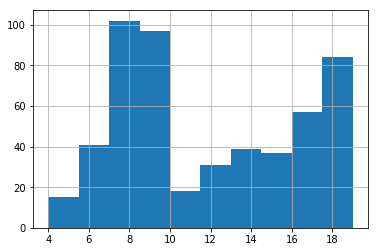

In [26]:
training_data_df[BEST_EPOCH].hist()

In [27]:
training_data_df[TOTAL_DURATION].describe()

count     521.000000
mean      900.059501
std       301.250481
min       538.000000
25%       576.000000
50%      1142.000000
75%      1176.000000
max      1322.000000
Name: Total_Duration(s), dtype: float64

In [28]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
3,54.0,0.813458,0.005863,0.800814,0.810065,0.813359,0.816576,0.829045
0,43.0,0.812952,0.005067,0.801767,0.809255,0.814016,0.816487,0.823169
1,47.0,0.812400,0.005994,0.797366,0.809296,0.813150,0.815805,0.824883
5,54.0,0.812156,0.005435,0.800747,0.809004,0.812420,0.816777,0.821525
2,54.0,0.812028,0.005019,0.798899,0.809439,0.812113,0.814720,0.825976
8,54.0,0.811578,0.005011,0.796920,0.808026,0.811954,0.814394,0.820760
6,54.0,0.811343,0.004753,0.802438,0.808184,0.811201,0.813985,0.826072
4,54.0,0.810744,0.005245,0.801478,0.806566,0.810941,0.814578,0.821117
7,54.0,0.809335,0.005767,0.797571,0.805152,0.808697,0.813616,0.822424


In [29]:
elmo_average = get_seconds('00:43:40')/20
elmo_average

131.0

In [30]:
elmo_transformer_average = get_seconds('00:25:23')/20
elmo_transformer_average

76.15

In [31]:
(elmo_average + elmo_transformer_average)/2

103.575

In [32]:
elmo_average_bs64 = get_seconds('00:31:54')/20
elmo_average_bs64

95.7

In [33]:
print(get_seconds('00:01:39'))
print(get_seconds('00:03:15'))
print(get_seconds('00:03:15') - get_seconds('00:01:39'))

99.0
195.0
96.0


In [34]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,521.0,0.811218,0.005823,0.000255,0.810717,0.811719


In [35]:
rp.summary_cont(training_data_df.groupby(MODEL))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Model,,,,,,
harem,260,0.810798,0.005862,0.000364,0.810085,0.811510
harem-ft,261,0.811637,0.005765,0.000357,0.810938,0.812336


In [36]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
fasttext,116,0.809858,0.005438,0.000505,0.808869,0.810848
glove,116,0.812160,0.006388,0.000593,0.810997,0.813322
none,56,0.812437,0.005182,0.000692,0.811080,0.813794
wang2vec,116,0.811950,0.005947,0.000552,0.810868,0.813032
word2vec,117,0.810324,0.005446,0.000503,0.809337,0.811311


In [37]:
rp.summary_cont(training_data_df.groupby(BATCH_SIZE))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Batch_Size,,,,,,
64,521,0.811218,0.005823,0.000255,0.810718,0.811718


In [38]:
rp.summary_cont(training_data_df.groupby(ELMO_DROPOUT))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
ELMo_Dropout,,,,,,
0,521,0.811218,0.005823,0.000255,0.810718,0.811718


In [39]:
rp.summary_cont(training_data_df.groupby([MODEL,EMBEDDING]))[TEST_F1_MEASURE]

N      Mean        SD        SE  95% Conf.  Interval
Model    Embedding                                                       
harem    fasttext   58  0.809513  0.005190  0.000682   0.808177  0.810849
         glove      59  0.811048  0.006182  0.000805   0.809471  0.812625
         none       27  0.812105  0.006207  0.001195   0.809764  0.814447
         wang2vec   58  0.811767  0.006247  0.000820   0.810159  0.813374
         word2vec   58  0.810250  0.005470  0.000718   0.808842  0.811658
harem-ft fasttext   58  0.810203  0.005700  0.000748   0.808736  0.811670
         glove      57  0.813311  0.006447  0.000854   0.811637  0.814984
         none       29  0.812746  0.004094  0.000760   0.811256  0.814236
         wang2vec   58  0.812134  0.005679  0.000746   0.810672  0.813595
         word2vec   59  0.810397  0.005468  0.000712   0.809002  0.811792

In [40]:
print(TEST_F1_MEASURE, MODEL, EMBEDDING, BATCH_SIZE, ELMO_DROPOUT)

Test_F1_Measure Model Embedding Batch_Size ELMo_Dropout


In [41]:
# Fits the model with the interaction term
# This will also automatically include the main effects for each factor
model = ols('Test_F1_Measure ~ C(Model)*C(Embedding)*C(Batch_Size)*C(ELMo_Dropout)', training_data_df).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

Overall model F( 9, 511) =  2.448, p =  0.0098


In [42]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Test_F1_Measure   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     2.448
Date:                Wed, 10 Apr 2019   Prob (F-statistic):            0.00983
Time:                        08:37:31   Log-Likelihood:                 1953.2
No. Observations:                 521   AIC:                            -3886.
Df Residuals:                     511   BIC:                            -3844.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         0.8095      0.001   1071.878      0.000       0.808       0.811
C(Model)[T.harem-ft]                              0.0007      0.001      0.646      0.518      -0.001       0.003
C(Embedding)[T.glove]                             0.0015      0.001      1.443      0.150      -0.001       0.004
C(Embedding)[T.none]                              0.0026      0.001      1.935      0.054   -4.03e-05       0.005
C(Embedding)[T.wang2vec]                          0.0023      0.001      2.110      0.035       0.000       0.004
C(Embedding)[T.word2vec]                          0.0007      0.001      0.690      0.491      -0.001       0.003
C(Model)[T.harem-ft]:C(Embedding)[T.glove]        0.0016      0.002      1.041      0.298      -0.001       0.005
C(Model)[T.harem-ft]:C(Embedding)[T.none]     -4.961e-05      0.002     -0.026      0.979      -0.004       0.004
C(Model)[T.harem-ft]:C(Embedding)[T.wang2vec]    -0.0003      0.002     -0.214      0.831      -0.003       0.003
C(Model)[T.harem-ft]:C(Embedding)[T.word2vec]    -0.0005      0.002     -0.360      0.719      -0.004       0.002
==============================================================================
Omnibus:                       22.445   Durbin-Watson:                   1.603
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.688
Skew:                          -0.417   Prob(JB):                     9.72e-07
Kurtosis:                       3.762   Cond. No.                         14.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
res = sm.stats.anova_lm(model, typ= 2)

ValueError: must have at least one row in constraint matrix

In [ ]:
res

In [ ]:
# Fits the model with the interaction term
# This will also automatically include the main effects for each factor
model = ols('Test_F1_Measure ~ C(Model)*C(Embedding)', training_data_df).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

In [ ]:
model.summary()

In [ ]:
sm.stats.anova_lm(model, typ= 2)

In [ ]:
# Fits the model with the interaction term
# This will also automatically include the main effects for each factor
model = ols('Test_F1_Measure ~ C(Model)+C(Embedding)', training_data_df).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

In [ ]:
model.summary()

In [ ]:
res = sm.stats.anova_lm(model, typ=2)
res

In [ ]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

anova_table(res)

In [ ]:
mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[MODEL])
mc_results = mc.tukeyhsd()
print(mc_results)

In [ ]:
mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[EMBEDDING])
mc_results = mc.tukeyhsd()
print(mc_results)

In [ ]:
mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[ELMO_DROPOUT])
mc_results = mc.tukeyhsd()
print(mc_results)

In [ ]:
mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[BATCH_SIZE])
mc_results = mc.tukeyhsd()
print(mc_results)